# Analysis of Yelp Business Intelligence Data
We will analyze a subset of Yelp's business, reviews and user data. This dataset comes to us from Kaggle although we have taken steps to pull this data into a publis s3 bucket: s3://sta9760-yelpdataset1/yelp-light/*business.json

In [1]:
%%info

ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
4,application_1588610942734_0005,pyspark,idle,Link,Link,


### Installation and Initial Setup

In [2]:
# install packages
sc.install_pypi_package('pandas==1.0.3')
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("seaborn==0.10.0")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
5,application_1588610942734_0006,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached pandas-1.0.3-cp36-cp36m-manylinux1_x86_64.whl (10.0 MB)
  Using cached python_dateutil-2.8.1-py2.py3-none-any.whl (227 kB)

  Using cached matplotlib-3.2.1-cp36-cp36m-manylinux1_x86_64.whl (12.4 MB)
  Using cached pyparsing-2.4.7-py2.py3-none-any.whl (67 kB)
  Using cached kiwisolver-1.2.0-cp36-cp36m-manylinux1_x86_64.whl (88 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)

  Using cached seaborn-0.10.0-py3-none-any.whl (215 kB)
  Using cached scipy-1.4.1-cp36-cp36m-manylinux1_x86_64.whl (26.1 MB)

In [3]:
# double check packages has been installed
sc.list_packages() 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version
-------------------------- -------
beautifulsoup4             4.8.1
boto                       2.49.0
cycler                     0.10.0
jmespath                   0.9.4
kiwisolver                 1.2.0
lxml                       4.4.2
matplotlib                 3.2.1
mysqlclient                1.4.6
nltk                       3.4.5
nose                       1.3.4
numpy                      1.14.5
pandas                     1.0.3
pip                        20.1
py-dateutil                2.2
pyparsing                  2.4.7
python-dateutil            2.8.1
python36-sagemaker-pyspark 1.2.6
pytz                       2019.3
PyYAML                     3.11
scipy                      1.4.1
seaborn                    0.10.0
setuptools                 46.1.3
six                        1.13.0
soupsieve                  1.9.5
wheel                      0.34.2
windmill                   1.6

### Importing

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### load data from s3 

In [5]:
df = spark.read.json('s3://sta9760-yelpdataset1/yelp_academic_dataset_business.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Overview of Data

In [6]:
#Display the number of rows and columns in our dataset.
print(f'Total Columns:{len(df.dtypes)}')
print(f'Total Rows:{df.count():,}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns:14
Total Rows:209,393

In [7]:
#Display the DataFrame schema below.
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

### Display the first 5 rows with the following columns:

business_id, name, city, state, categories


In [8]:

df.createOrReplaceTempView('YelpBusiness')

sqldf = spark.sql(
'''
SELECT `business_id`, `name`, `city`, `state`, `categories`
FROM YelpBusiness

'''
)
sqldf.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+---------------+-----+--------------------+
|         business_id|                name|           city|state|          categories|
+--------------------+--------------------+---------------+-----+--------------------+
|f9NumwFMBDn751xgF...|The Range At Lake...|      Cornelius|   NC|Active Life, Gun/...|
|Yzvjg0SayhoZgCljU...|   Carlos Santo, NMD|     Scottsdale|   AZ|Health & Medical,...|
|XNoUzKckATkOD1hP6...|             Felinus|       Montreal|   QC|Pets, Pet Service...|
|6OAZjbxqM5ol29BuH...|Nevada House of Hose|North Las Vegas|   NV|Hardware Stores, ...|
|51M2Kk903DFYI6gnB...|USE MY GUY SERVIC...|           Mesa|   AZ|Home Services, Pl...|
+--------------------+--------------------+---------------+-----+--------------------+
only showing top 5 rows

### Analyzing Categories
Let's now answer this question: **how many unique categories are represented in this dataset?**

Display the first 5 rows of your association table below.

In [9]:
from pyspark.sql.functions import *

df1 = sqldf.select(col("business_id"), explode(split(col("categories"), ",")).alias('categories'))
df1=df1.withColumn('categories', ltrim(df1.categories))
df1.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------------+
|         business_id|      categories|
+--------------------+----------------+
|f9NumwFMBDn751xgF...|     Active Life|
|f9NumwFMBDn751xgF...|Gun/Rifle Ranges|
|f9NumwFMBDn751xgF...|     Guns & Ammo|
|f9NumwFMBDn751xgF...|        Shopping|
|Yzvjg0SayhoZgCljU...|Health & Medical|
+--------------------+----------------+
only showing top 5 rows

### Total Unique Categories
Finally, we are ready to answer the question: **what is the total number of unique categories available?**

In [10]:
df1.select('categories').distinct().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1336

In [11]:
df1.groupBy('categories').count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-----+
|         categories|count|
+-------------------+-----+
|     Dermatologists|  341|
|   Historical Tours|   54|
|Mobile Home Dealers|   16|
|     Paddleboarding|   36|
|   Hot Air Balloons|   21|
|       Aerial Tours|   28|
|      Skating Rinks|  104|
|  Signature Cuisine|    1|
|             Fondue|   54|
|      Data Recovery|  195|
|  Pet Waste Removal|   34|
|      Videographers|  169|
|    Pet Photography|   49|
|        Boat Repair|  100|
|            Beaches|   74|
|       Contract Law|   13|
|        Hobby Shops|  828|
|           Day Spas| 2880|
|              Reiki|  312|
|           Honduran|    8|
+-------------------+-----+
only showing top 20 rows

### Bar Chart of Top Categories
With this data available, let us now build a barchart of the top 20 categories.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

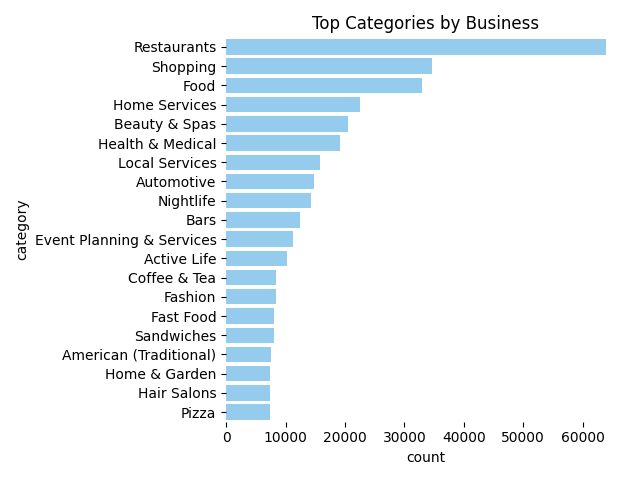

In [12]:
top20 = df1.groupby('categories').count().sort(desc("count")).limit(20).toPandas()
#print(top20)
sns.barplot(top20['count'],top20['categories'],color="lightskyblue")
plt.title('Top Categories by Business')
plt.xlabel('count')
plt.ylabel('category')
plt.tight_layout()
plt.box(False)
%matplot plt

## Do Yelp Reviews Skew Negative?
Oftentimes, it is said that the only people who write a written review are those who are extremely dissatisfied or extremely satisfied with the service received.

How true is this really? Let's try and answer this question.

### Loading Review Data

In [13]:
df_review= spark.read.json('s3://sta9760-yelpdataset1/yelp_academic_dataset_review.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [51]:
df_review.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

In [52]:
df3= df_review.where(col("text").isNotNull()).groupby(df_review.business_id).agg(avg(col("stars")))
df3.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|         business_id|        avg(stars)|
+--------------------+------------------+
|ATeOjZzE3VOI-RW7F...| 3.433734939759036|
|RMjCnixEY5i12Ciqn...|3.5316455696202533|
|vbUABNAQI2iwN7v0x...|2.4545454545454546|
|VHsNB3pdGVcRgs6C3...| 3.411764705882353|
|r-W1HPIZ3V6S2DaXh...| 4.852459016393443|
+--------------------+------------------+
only showing top 5 rows

In [53]:
#df4 = df_review.groupby(df_review.business_id).agg(avg(col("stars")))
df_merge = df.join(df3, on=['business_id'])
df_merge.select("avg(stars)","stars","name","city","state").sort(desc("avg(stars)")).show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----+--------------------+---------------+-----+
|avg(stars)|stars|                name|           city|state|
+----------+-----+--------------------+---------------+-----+
|       5.0|  5.0|Diamond Finish De...|      Avon Lake|   OH|
|       5.0|  5.0|DB Mobile Notary ...|      Las Vegas|   NV|
|       5.0|  5.0|         Xoxo Lashes|North Las Vegas|   NV|
|       5.0|  5.0|          Econolight|        Phoenix|   AZ|
|       5.0|  5.0|         Beezy Booth|         Peoria|   AZ|
+----------+-----+--------------------+---------------+-----+
only showing top 5 rows

### Skewness Test
(row['avg(stars)'] - row['stars']) / row['stars']

In [54]:
dfnew = df_merge.select("avg(stars)","stars").sort("avg(stars)",ascending=False)
#dfnew1 = df_merge.select("avg(stars)","stars").sort("avg(stars)",ascending=False)
df_skewness = dfnew.withColumn("skewness", ((dfnew["avg(stars)"]-dfnew["stars"])/dfnew["stars"])).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

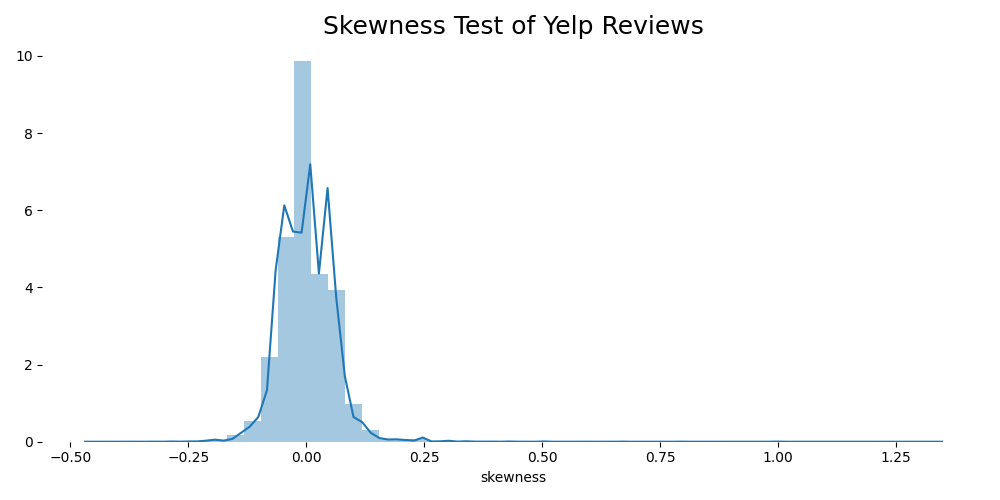

In [55]:
plt.clf()
plt.title('Skewness Test of Yelp Reviews',fontsize=18)
sns.distplot(df_skewness['skewness'])
plt.box(False)
plt.tight_layout()
%matplot plt

**Question:**
So, do Yelp (written) Reviews skew negative? Does this analysis actually prove anything? Expound on implications / interpretations of this graph.

In [56]:
print('Answer: The histogram shows there are more data in the left symmetric part. We also can observe that the data is almost symmetric with a slightly positive sknewness. That means users who left a text review were more satisfied than normal, even though this phenomenon is not obvious.')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Answer: The histogram shows there are more data in the left symmetric part. We also can observe that the data is almost symmetric with a slightly positive sknewness. That means users who left a text review were more satisfied than normal, even though this phenomenon is not obvious.

#  How many elites are there in different states?

In [57]:
df_user= spark.read.json('s3://sta9760-yelpdataset1/yelp_academic_dataset_user.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [58]:
df_user.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)

First, I merged YelpBusiness and YelpReview by business_id, then I merged this new data with YelpUser by user_id.

In [63]:
df_review.createOrReplaceTempView('YelpReview')
df_user.createOrReplaceTempView('YelpUser')
data= spark.sql(
'''
SELECT U.user_id, U.elite,U.average_stars, B.state, R.stars
FROM YelpBusiness as B
INNER JOIN YelpReview as R
ON B.business_id= R.business_id
INNER JOIN YelpUser as U
ON R.user_id = U.user_id

'''
)
data .show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+-------------+-----+-----+
|             user_id|               elite|average_stars|state|stars|
+--------------------+--------------------+-------------+-----+-----+
|-0Ji0nOyFe-4yo8BK...|                    |         3.12|   NC|  4.0|
|-0XPr1ilUAfp-yIXZ...|                    |         1.25|   PA|  2.0|
|-1KKYzibGPyUX-Mwk...|2011,2012,2013,20...|          4.0|   WI|  4.0|
|-1zQA2f_syMAdA04P...|                    |         3.29|   NV|  5.0|
|-1zQA2f_syMAdA04P...|                    |         3.29|   NV|  5.0|
+--------------------+--------------------+-------------+-----+-----+
only showing top 5 rows

In [64]:
# count the top 10 number of elites by state
data.createOrReplaceTempView('Merge_all')
elite_num= spark.sql(
'''
SELECT COUNT(elite) as elite_num, state
FROM Merge_all
GROUP BY state
ORDER BY elite_num desc
'''
)
elite_num .show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-----+
|elite_num|state|
+---------+-----+
|  2802658|   NV|
|  2504395|   AZ|
|   911263|   ON|
|   509191|   NC|
|   389292|   OH|
|   352805|   PA|
|   208166|   QC|
|   152283|   WI|
|   112577|   AB|
|    47647|   IL|
+---------+-----+
only showing top 10 rows

In [65]:
# changed data to pandas for ploting
top10 = elite_num.limit(10).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

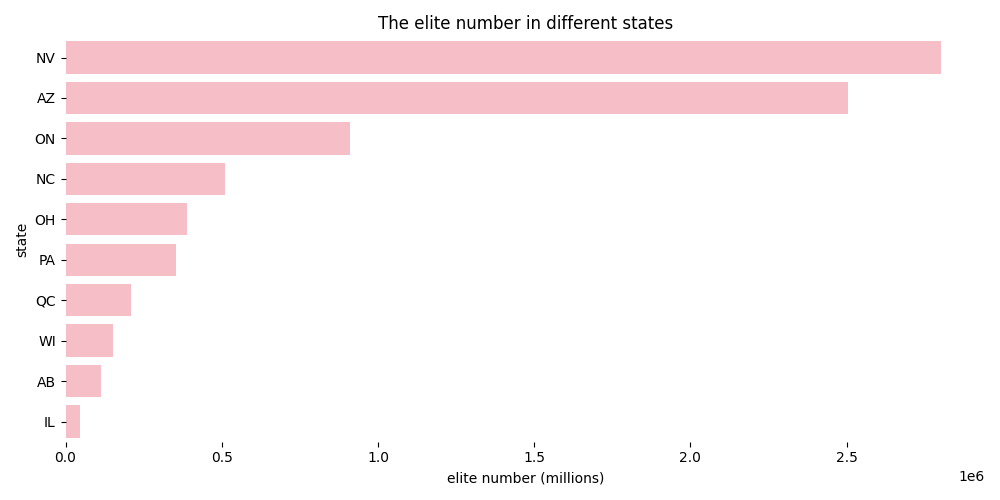

In [66]:
plt.clf()
sns.barplot(top10['elite_num'],top10['state'],color="lightpink")
plt.title('The elite number in different states')
plt.xlabel('elite number (millions)')
plt.ylabel('state')
plt.tight_layout()
plt.box(False)
%matplot plt

In [67]:
print('As we can see from the plot, the top 1 is in New York with about 2.8 million elites. That makes sense, since New York is not only a densely-populated state but also a tourist attraction". The second one is in Arizona with approxiate 2.5 millon elites. Then the following are all lower than 1 million.')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

As we can see from the plot, the top 1 is in New York with about 2.8 million elites. That makes sense, since New York is not only a densely-populated state but also a tourist attraction". The second one is in Arizona with approxiate 2.5 millon elites. Then the following are all lower than 1 million.